In [1]:
import numpy as np
import jax
from jax import jit, vmap, grad, random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from scipy.optimize import fsolve, root, bisect
import os 
if not os.path.exists('figures'):
    os.makedirs('figures')

%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid')
!nvidia-smi

Wed May  1 00:17:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:4B:00.0 Off |                    0 |
| N/A   25C    P0              50W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
def df_1(etas, lamb):
  return jnp.mean(etas/(lamb+etas))

def df_1_bar(etas, lamb, sigma):
  return jnp.mean(etas/(lamb+etas)) + sigma**2/lamb

def df_2(etas, lamb):
  return jnp.mean((etas/(lamb+etas))**2)

def tf_1(etas, ws, lamb):
  return jnp.sum((ws**2) * etas/(lamb+etas))

def tf_1p(etas, ws, lamb):
  return jnp.sum((ws**2)*etas/(lamb+etas)**2)

def tf_2(etas, ws, lamb):
  return jnp.sum((ws**2) * etas**2/(lamb+etas)**2)

def newton(f, x0, max_step=100, abs_tol=1e-5, rel_tol=1e-10, eta=1.0):
    x = x0
    gf = grad(f)
    for _ in range(max_step):
        x_next = x - eta*f(x)/gf(x)
        if abs(f(x_next)) < abs_tol:
            return x_next
        x = x_next
    return None

def solve_kappa2(P,  Ns:list, lamb, etaX, sigma_xi=0.0, upper_bound=None, anneal_steps=1, **kwargs):
  if not upper_bound:
    upper_bound = lamb + 1e3
  D = Ns[0]
  if lamb == 0:
    if D == min(P, *Ns):
      return 0
    elif P == min(P, *Ns):
      fn = lambda kappa: 1 - D/P * df_1_bar(etaX, kappa, sigma_xi)
    else:
      N = min(Ns)
      fn = lambda kappa: N/D - df_1_bar(etaX, kappa, sigma_xi)
    return newton(fn, x0=1.0, **kwargs)
  
  def fn_lamb(kappa, lamb):
    ans = kappa * (1 - D/P * df_1_bar(etaX, kappa, sigma_xi))
    for N in Ns[1:]:
      ans *= N/D - df_1_bar(etaX, kappa, sigma_xi)
    return ans - lamb
  anneal_schedule = np.logspace(np.log10(lamb), 0, num=anneal_steps+1)[::-1]
  kappa = upper_bound
  for anneal_lamb in anneal_schedule:
    fn = lambda kappa: fn_lamb(kappa, anneal_lamb)
    kappa_next = newton(fn, x0=kappa, **kwargs)
    if not kappa_next: 
      print("Annealing didn't find kappa. Returning last value.")
      return kappa
    kappa = kappa_next
  return kappa

def estimate_df1_kappa1(lamb, X_tr, FX_tr):
  P, D = X_tr.shape
  N = FX_tr.shape[1]
  q = D/P
  if q >= 1:
    gram = FX_tr @ FX_tr.T / P
    df1 = jnp.trace(jnp.linalg.inv(gram + lamb*np.identity(P)) @ gram)/D
    kappa1 = (jnp.trace(jnp.linalg.inv(gram + lamb*np.identity(P)))/P)**(-1)
    return df1, kappa1
    
  else:
    cov = FX_tr.T @ FX_tr / P
    df1 = jnp.trace(jnp.linalg.inv(cov + lamb*np.identity(N)) @ cov)/D
    kappa1 = lamb/(1-q * df1)
    return df1, kappa1

def cantor_pairing(i, j):
  return (i + j) * (i + j + 1) // 2 + j


In [3]:
def simulate_theory(Ns, qs, lambs, sigma_epsilons, sigma_xis, X_spec, F_specs, teacher, X_te, Xi_te, y_te, num_X_seeds, num_F_seeds):
    if type(lambs) not in [list, np.ndarray]:
        lambs = [lambs]*len(qs)
    if type(sigma_epsilons) not in [list, np.ndarray]:
        sigma_epsilons = [sigma_epsilons]*len(qs)
    if type(sigma_xis) not in [list, np.ndarray]:
        sigma_xis = [sigma_xis]*len(qs)
    lambs, sigma_epsilons, sigma_xis = np.array(lambs), np.array(sigma_epsilons), np.array(sigma_xis)
    data = {}
    L, D, N = len(Ns), Ns[0], Ns[-1]
    Ss = [jnp.diag(X_spec)] + [jnp.diag(F_spec) for F_spec in F_specs]
    for i in tqdm(range(len(qs))):
        q, lamb, sigma_epsilon, sigma_xi = qs[i], lambs[i], sigma_epsilons[i], sigma_xis[i]
        P = int(D/q)
        y_hats = np.zeros((num_X_seeds, num_F_seeds, X_te.shape[0]))
        y_hats_clean = np.zeros((num_X_seeds, num_F_seeds, X_te.shape[0]))
        df1_empirical = np.zeros((num_X_seeds, num_F_seeds))
        kappa_GCV = np.zeros((num_X_seeds, num_F_seeds))
        Etrs = np.zeros((num_X_seeds, num_F_seeds))
        s_vals = {}
        for X_seed in range(num_X_seeds):
            X_key = random.PRNGKey(X_seed)
            X_tr_key, e_key= random.split(X_key)
            epsilon = random.normal(e_key, (P, )) * sigma_epsilon
            X_tr = random.normal(X_tr_key, (P, D)) @ jnp.sqrt(Ss[0])
            y_tr = X_tr @ teacher + epsilon
            y_tr_clean = X_tr @ teacher
            for F_seed in range(num_F_seeds):
                F_key = random.PRNGKey(F_seed)
                Xi_key = random.PRNGKey(cantor_pairing(X_seed, F_seed))
                F_keys = random.split(F_key, L)
                F = jnp.identity(D)
                for l in range(1, L):
                    F_l = random.normal(F_keys[l], (Ns[l-1], Ns[l])) @ jnp.sqrt(Ss[l])/np.sqrt(D)
                    F = F @ F_l
                Xi = random.normal(Xi_key, (P, N)) * sigma_xi
                FX_tr = (X_tr @ F + Xi)
                FX_te = (X_te @ F + Xi_te)
                            
                if lamb == 0:
                    soln = jnp.linalg.lstsq(FX_tr, y_tr, rcond=None)
                    w_star, s_val = soln[0], soln[-1]
                    w_star_clean = jnp.linalg.lstsq(FX_tr, y_tr_clean, rcond=None)[0]
                    y_hat_tr = FX_tr @ w_star
                    Etrs[X_seed, F_seed] = jnp.mean((y_tr - y_hat_tr)**2)
                    s_vals[(X_seed, F_seed)] = s_val
                elif P > N:
                    cov = FX_tr.T @ FX_tr / P
                    w_star = jnp.linalg.solve(cov + lamb*np.identity(N), FX_tr.T @ y_tr / P)
                    w_star_clean = jnp.linalg.solve(cov + lamb*np.identity(N), FX_tr.T @ y_tr_clean / P)
                    y_hat_tr = FX_tr @ w_star
                    Etrs[X_seed, F_seed] = jnp.mean((y_tr - y_hat_tr)**2)
                else: 
                    gram = FX_tr @ FX_tr.T / P
                    w_star = FX_tr.T @ jnp.linalg.solve(gram + lamb*np.identity(P), y_tr) / P
                    w_star_clean = FX_tr.T @ jnp.linalg.solve(gram + lamb*np.identity(P), y_tr_clean) / P
                    Etrs[X_seed, F_seed] = lamb**2/P * jnp.sum((jnp.linalg.solve(gram + lamb*np.identity(P),  y_tr))**2)

                y_hats[X_seed, F_seed, :] = FX_te @ w_star
                y_hats_clean[X_seed, F_seed, :] = FX_te @ w_star_clean
                    
                df1_emp, kappa1 = estimate_df1_kappa1(lamb, X_tr, FX_tr)
                df1_empirical[X_seed, F_seed] = df1_emp
                kappa_GCV[X_seed, F_seed] = kappa1

        Eg = np.mean((y_hats - y_te[None, None, :])**2, axis=-1)
        Signal = np.mean((y_hats_clean - y_te[None, None, :])**2, axis=-1)
        Noise = np.mean((y_hats - y_hats_clean)**2, axis=-1)
        Bias =  np.mean((y_te - np.mean(y_hats_clean, axis=(0, 1)))**2)
        VarX = np.mean((jnp.mean(y_hats_clean, axis=1) - y_te[None, :])**2, axis=-1) - Bias
        VarF = np.mean((jnp.mean(y_hats_clean, axis=0) - y_te[None, :])**2, axis=-1) - Bias
        VarXF =  Signal - VarX - VarF - Bias
        VarXe = jnp.mean((jnp.mean(y_hats - y_hats_clean, axis=1))**2, axis=-1)
        VarXFe = Noise - VarXe
        data[q] = {
            'Eg': np.mean(Eg),
            'Eg_std': np.std(Eg),
            'Signal': np.mean(Signal),
            'Signal_std': np.std(Signal),
            'Noise': np.mean(Noise),
            'Noise_std': np.std(Noise),
            'Bias': Bias,
            'VarX': np.mean(VarX),
            'VarX_std': np.std(VarX),
            'VarF': np.mean(VarF),
            'VarF_std': np.std(VarF),
            'VarXF': np.mean(VarXF),
            'VarXF_std': np.std(VarXF),
            'VarXe': np.mean(VarXe),
            'VarXe_std': np.std(VarXe),
            'VarXFe': np.mean(VarXFe),
            'VarXFe_std': np.std(VarXFe),
            'Etr': np.mean(Etrs),
            'Etr_std': np.std(Etrs),
            'df1': np.mean(df1_empirical),
            'df1_std': np.std(df1_empirical),
            'kappa_GCV': np.mean(kappa_GCV),
            'kappa_GCV_std': np.std(kappa_GCV)
        }
        if lamb == 0:
            data[q]['s_vals'] = s_vals

    dataT = {}
    for key in data[qs[0]]:
        dataT[key] = np.array([data[q][key] for q in data])
    return dataT
    
def solve_theory(Ns, qs, lambs, sigma_epsilons, sigma_xis, X_spec, F_spec, teacher, anneal_steps=0, **kwargs):
    if type(lambs) != list:
        lambs = np.array([lambs]*len(qs))
    if type(sigma_epsilons) != list:
        sigma_epsilons = np.array([sigma_epsilons]*len(qs))
    if type(sigma_xis) != list:
        sigma_xis = np.array([sigma_xis]*len(qs))
    D = Ns[0]
    kappa2 = jnp.array([
        solve_kappa2(D/q, Ns, lamb=lamb, etaX=X_spec, sigma_xi=sx, anneal_steps=anneal_steps, **kwargs)
          for lamb, q, sx in zip(lambs, qs, sigma_xis)])
    df1k2_bar = jnp.array([df_1_bar(X_spec, k, sx) for k, sx in zip(kappa2, sigma_xis)])
    df1k2 = jnp.array([df_1(X_spec, k) for k in kappa2])
    df2k2 = jnp.array([df_2(X_spec, k) for k in kappa2])
    tf1pk2 = jnp.array([tf_1p(X_spec, teacher, k) for k in kappa2])
    tf1k2 = jnp.array([tf_1(X_spec, teacher, k) for k in kappa2])
    tf2k2 = jnp.array([tf_2(X_spec, teacher, k) for k in kappa2])
    gamma2 = qs * df2k2
    kappa1 = kappa2
    for N in Ns[1:]:
        kappa1 *= (N/D - df1k2_bar)
    dlogS = 0
    for N in Ns[1:]:
        dlogS += df1k2_bar/(N/D - df1k2_bar)
    dlogk1k2 = 1 + (df1k2_bar-df2k2)/df1k2_bar * dlogS
    dlogk2k1 = 1/dlogk1k2
    gamma1 = qs * df1k2_bar * (1 - (df1k2_bar - df2k2)/df1k2_bar * dlogk2k1)
    
    signal = (kappa2**2 * tf1pk2 * dlogk2k1 + kappa2*tf1k2 * ( 1 - dlogk2k1) ) /(1-gamma1)
    noise = sigma_epsilons**2 * gamma1/(1-gamma1)
    bias = kappa2**2 * tf1pk2
    varX = kappa2**2 * tf1pk2 * gamma2/(1-gamma2)
    varXe = sigma_epsilons**2 * gamma2/(1-gamma2)
    varXFe = noise - varXe
    varF = (1 - dlogk2k1) * kappa2 * tf2k2
    varXF = signal - varX - varF - bias
    Eg = signal + noise
    Etr = ((lambs/kappa1)**2)*(Eg + sigma_epsilons**2)
    data = {
        'kappa2': kappa2,
        'kappa1': kappa1,
        'df1k2_bar': df1k2_bar,
        'df1k2': df1k2,
        'df2k2': df2k2,
        'tf1pk2': tf1pk2,
        'tf1k2': tf1k2,
        'tf2k2': tf2k2,
        'dlogS': dlogS,
        'dlogk2k1': dlogk2k1,
        'dlogk1k2': dlogk1k2,
        'gamma1': gamma1,
        'gamma2': gamma2,
        'Bias': bias,
        'VarX': varX,
        'VarF': varF,
        'VarXF': varXF,
        'VarXe': varXe,
        'VarXFe': varXFe,
        'Noise': noise,
        'Signal': signal,
        'Eg': Eg,
        'Etr': Etr
    }
    return data

## Unstructured Data

In [419]:
qs = np.logspace(-2, 2, 20)
P_te = 200
sigma_epsilon = 0.25
sigma_xi = 0.5

D = 200
N = 100
num_F_seeds = 25
num_X_seeds = 25

lamb = 1e-3

etasX = jnp.arange(1, D+1)**(-0.0)
etasF = jnp.arange(1, N+1)**(-0.0)
SX = jnp.diag(etasX)
w = jnp.arange(1, D+1)**(-0.0)
w = w / jnp.sqrt(jnp.sum(w**2))

X_te_key, Xi_te_key = random.split(random.PRNGKey(0))
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
Xi_te = random.normal(Xi_te_key, (P_te, N)) * sigma_xi
y_te = X_te @ w


expt = simulate_theory([D, N], qs, lamb, sigma_epsilon, sigma_xi, etasX, [etasF], w, X_te, Xi_te, y_te, num_X_seeds, num_F_seeds)

qs2 = qs
thry = solve_theory([D, N], qs2, lamb, sigma_epsilon, sigma_xi, etasX, [etasF], w, anneal_steps=5)


100%|██████████| 20/20 [01:12<00:00,  3.65s/it]


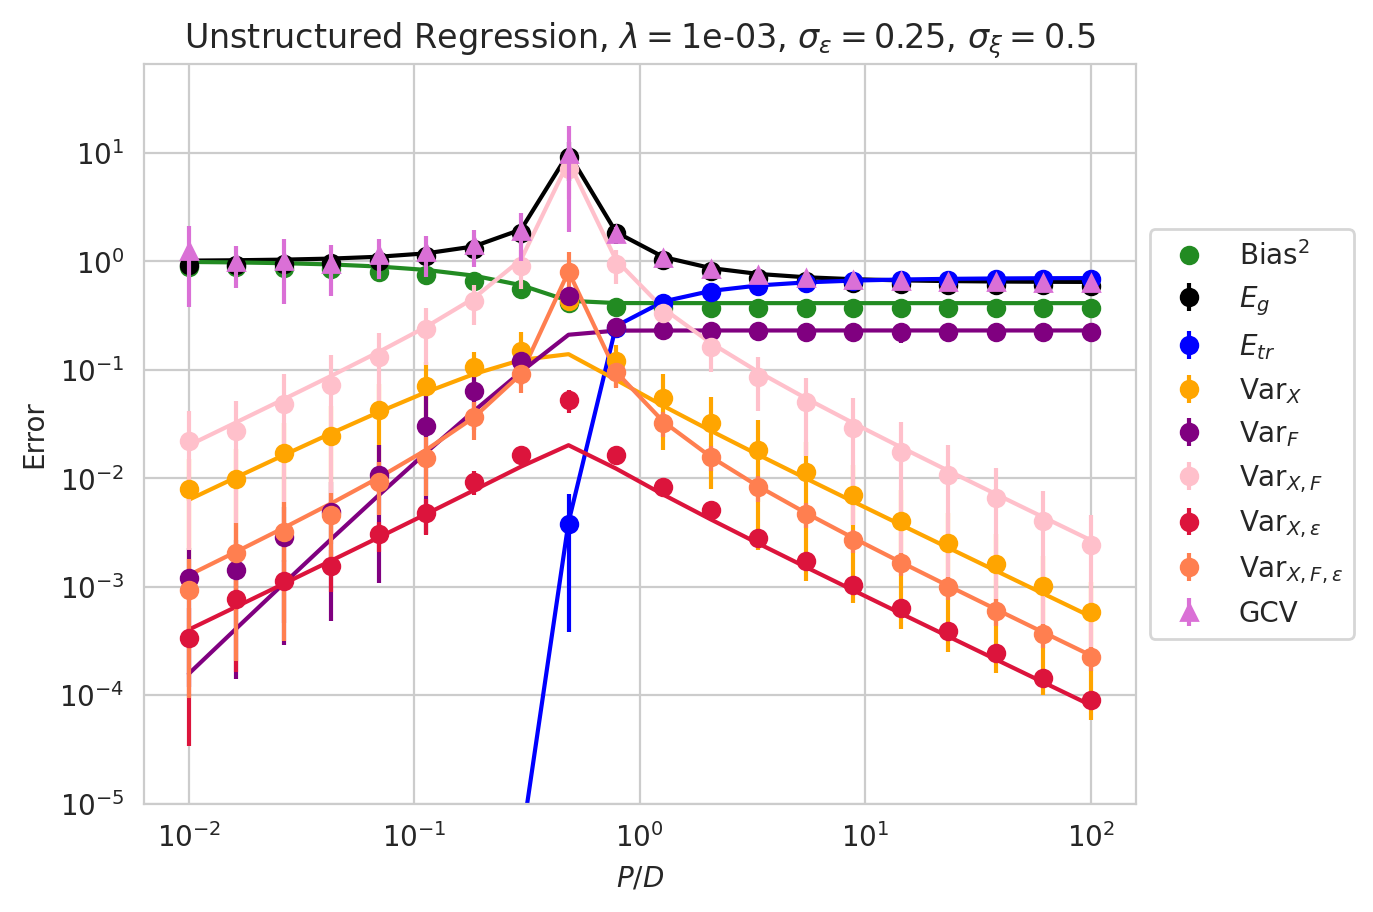

In [29]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF', 'VarXe', 'VarXFe']
colors = ['k', 'b', 'forestgreen', 'orange', 'purple', 'pink', 'crimson', 'coral']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$", "Var$_{{X, \\epsilon}}$", "Var$_{{X, F, \\epsilon}}$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(1/qs, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(1/qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(1/qs2, thry[key], c=color)

E_GCV = (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2
E_GCV_std = (expt['kappa_GCV']/lamb)**2 * expt['Etr_std']
E_GCV_std = np.where(E_GCV_std > E_GCV, E_GCV_std/2, E_GCV_std)
plt.errorbar(1/qs, E_GCV,  E_GCV_std/1.2, c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.xlabel(r'$P/D$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.ylim(bottom=1e-5, top=None)
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}, $\\sigma_\\xi=${sigma_xi}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('figures/unstructured_NLRF.pdf', bbox_inches='tight')

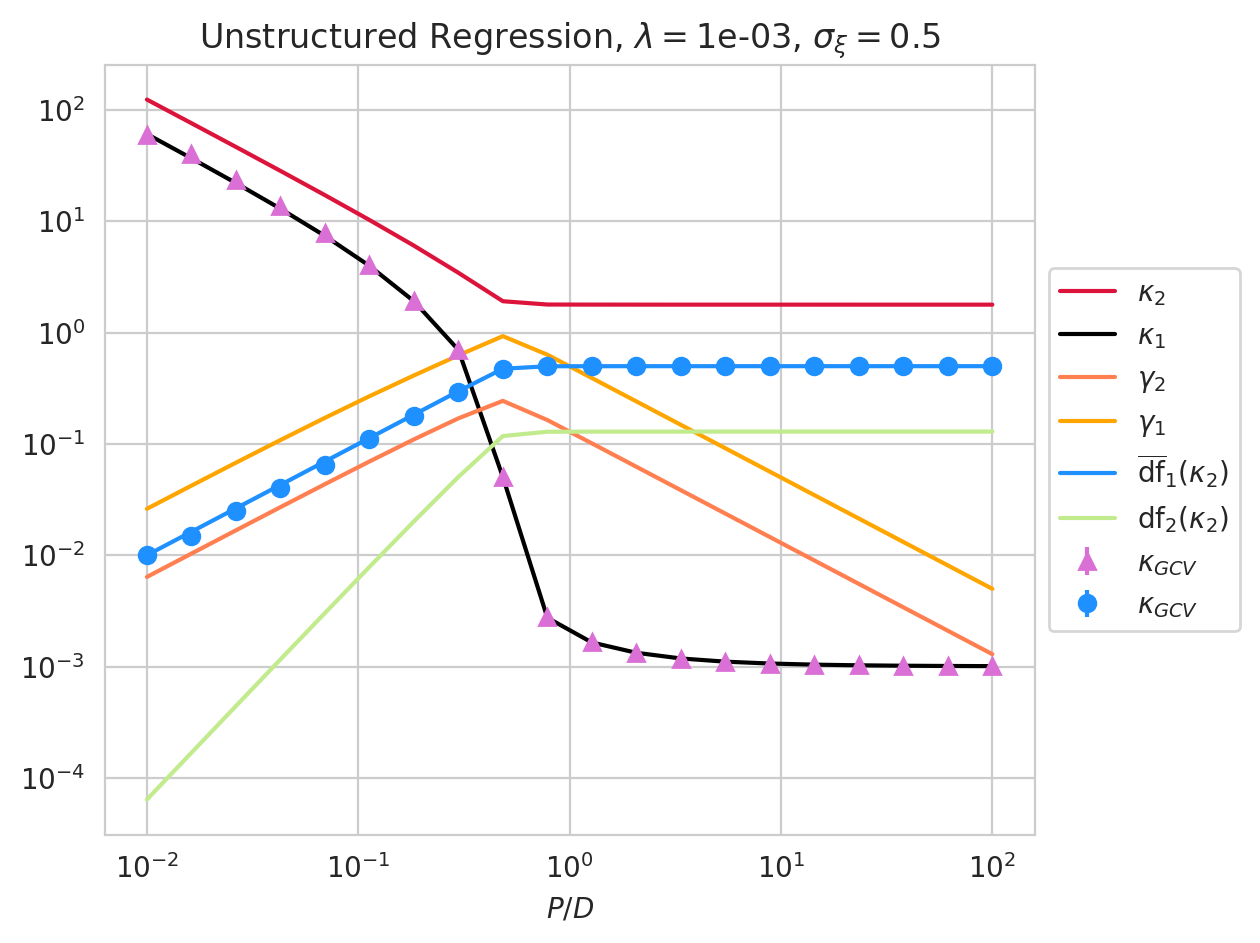

In [431]:
sns.set_palette('rainbow', n_colors=7)
plt.figure(figsize=(6, 5))
plt.plot(1/qs2, thry['kappa2'], label="$\\kappa_2$", c='crimson')
plt.plot(1/qs2, thry['kappa1'], label="$\\kappa_1$", c='k')
plt.plot(1/qs2, thry['gamma2'], label="$\\gamma_2$", c='coral')
plt.plot(1/qs2, thry['gamma1'], label="$\\gamma_1$", c='orange')
plt.plot(1/qs2, thry['df1k2_bar'],  label="$\\overline{{\\mathrm{{df}}}}_1(\\kappa_2)$", c='dodgerblue')
plt.plot(1/qs2, thry['df2k2'], label="df$_2(\\kappa_2)$", c='C4')
plt.errorbar(1/qs2, expt['kappa_GCV'], expt['kappa_GCV_std'], marker='^', linestyle='', label="$\\kappa_{GCV}$", c='orchid')
plt.errorbar(1/qs2, expt['df1'], expt['df1_std'], marker='o', linestyle='',label="$\\kappa_{GCV}$", c='dodgerblue')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$P/D$')
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}, $\\sigma_{{\\xi}}=${sigma_xi}")
plt.savefig('figures/NLRF_unstructured_params.pdf', bbox_inches='tight')

In [31]:
D = 10_000
N = 2_000
qs2 = qs
sigma_xi = 5e-3
alpha=1.5
lamb = 1e-8
etasX = jnp.arange(1, D+1)**(-alpha)
w = jnp.arange(1, D+1)**(-0.0)
w = w / jnp.sqrt(jnp.sum(w**2))
# thry = solve_theory([D, N], qs2, lamb, sigma_epsilon, sigma_xi, etasX, [etasF], w, anneal_steps=4)
thry0 = solve_theory([D, N], qs2, lamb, sigma_epsilon, 0.0, etasX, [etasF], w, anneal_steps=4)

Text(0.5, 1.0, 'Unstructured Regression, $\\lambda=$1e-03, $\\sigma_{\\xi}=$0.5')

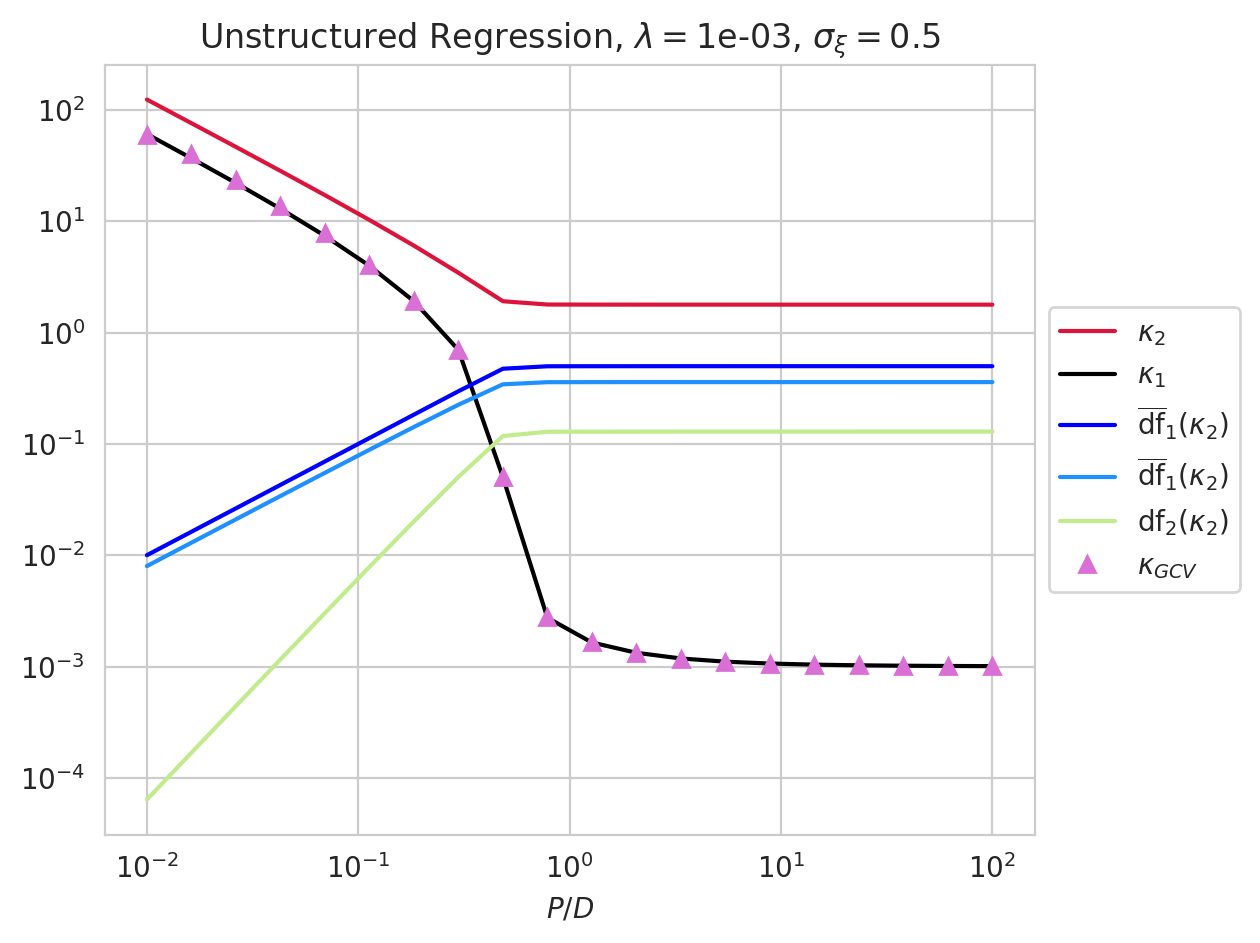

In [422]:
sns.set_palette('rainbow', n_colors=7)
plt.figure(figsize=(6, 5))
plt.plot(1/qs2, thry['kappa2'], label="$\\kappa_2$", c='crimson')
# plt.plot(1/qs2, thry0['kappa2'], '--', label="$\\kappa_2$", c='crimson')
plt.plot(1/qs2, thry['kappa1'], label="$\\kappa_1$", c='k')
# plt.plot(1/qs2, thry0['kappa1'], '--', label="$\\kappa_1$", c='k')
# plt.plot(1/qs2, thry['gamma2'], label="$\\gamma_2$", c='coral')
# plt.plot(1/qs2, thry0['gamma2'], '--', label="$\\gamma_2$", c='coral')
# plt.plot(1/qs2, thry['gamma1'], label="$\\gamma_1$", c='orange')
# plt.plot(1/qs2, thry0['gamma1'], '--', label="$\\gamma_1$", c='orange')
plt.plot(1/qs2, thry['df1k2_bar'],  label="$\\overline{{\\mathrm{{df}}}}_1(\\kappa_2)$", c='blue')
plt.plot(1/qs2, thry['df1k2'],  label="$\\overline{{\\mathrm{{df}}}}_1(\\kappa_2)$", c='dodgerblue')
# plt.plot(1/qs2, thry0['df1k2'], '--',  label="df$_1(\\kappa_2)$", c='dodgerblue')
plt.plot(1/qs2, thry['df2k2'], label="df$_2(\\kappa_2)$", c='C4')
# plt.plot(1/qs2, thry0['df2k2'], '--', label="df$_2(\\kappa_2)$", c='C4')

plt.plot(1/qs2, expt['kappa_GCV'], '^', label="$\\kappa_{GCV}$", c='orchid')

# plt.plot(1/qs2, sigma_xi**2/(1-qs2*thry['df1k2']), '--', c='red')
# plt.plot(1/qs2, 1e-5*qs2**(alpha), '--', c='darkorchid')
# plt.plot(1/qs2, qs2 * sigma_xi**2, '--', c='pink')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$P/D$')
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}, $\\sigma_{{\\xi}}=${sigma_xi}")
# plt.savefig('figures/NLRF_unstructured_params.pdf', bbox_inches='tight')

## Structured

### Transition

In [62]:
D = 10_000
N = 5_000
qs = np.logspace(0.5, 4, 12)
qs2 = np.logspace(0, 4, 40)
ps = D/qs 
ps2 = D/qs2
P_te = 200

num_F_seeds = 5
num_X_seeds = 5

sigma_epsilon = 0
# sigma_xi_t = 4e-3
sigma_xi_t = 4e-2
sigma_xi =  sigma_xi_t * np.sqrt(1/ D)
lamb = 1e-8

# alpha1 = 4.0
alpha1 = 3.0
alpha2 = 0.0
r = 0.4
etasX = jnp.arange(1, D+1)**(-alpha1)
etasF = jnp.arange(1, N+1)**(-alpha2)
SX = jnp.diag(etasX)
w = jnp.arange(1, D+1)**(-(1 + alpha1*(2*r-1))/2)

X_te_key, Xi_te_key = random.split(random.PRNGKey(0))
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
Xi_te = random.normal(Xi_te_key, (P_te, N)) * sigma_xi
y_te = X_te @ w

expt = simulate_theory([D, N], qs, lamb, sigma_epsilon, sigma_xi, etasX, [etasF], w, X_te, Xi_te, y_te, num_X_seeds, num_F_seeds)
thry = solve_theory([D, N], qs2, lamb, sigma_epsilon, sigma_xi, etasX, [etasF], w, anneal_steps=24)


100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


In [53]:
qs2 = np.logspace(0, 4, 40)
thry = solve_theory([D, N], qs2, lamb, sigma_epsilon, sigma_xi, etasX, [etasF], w, anneal_steps=24)

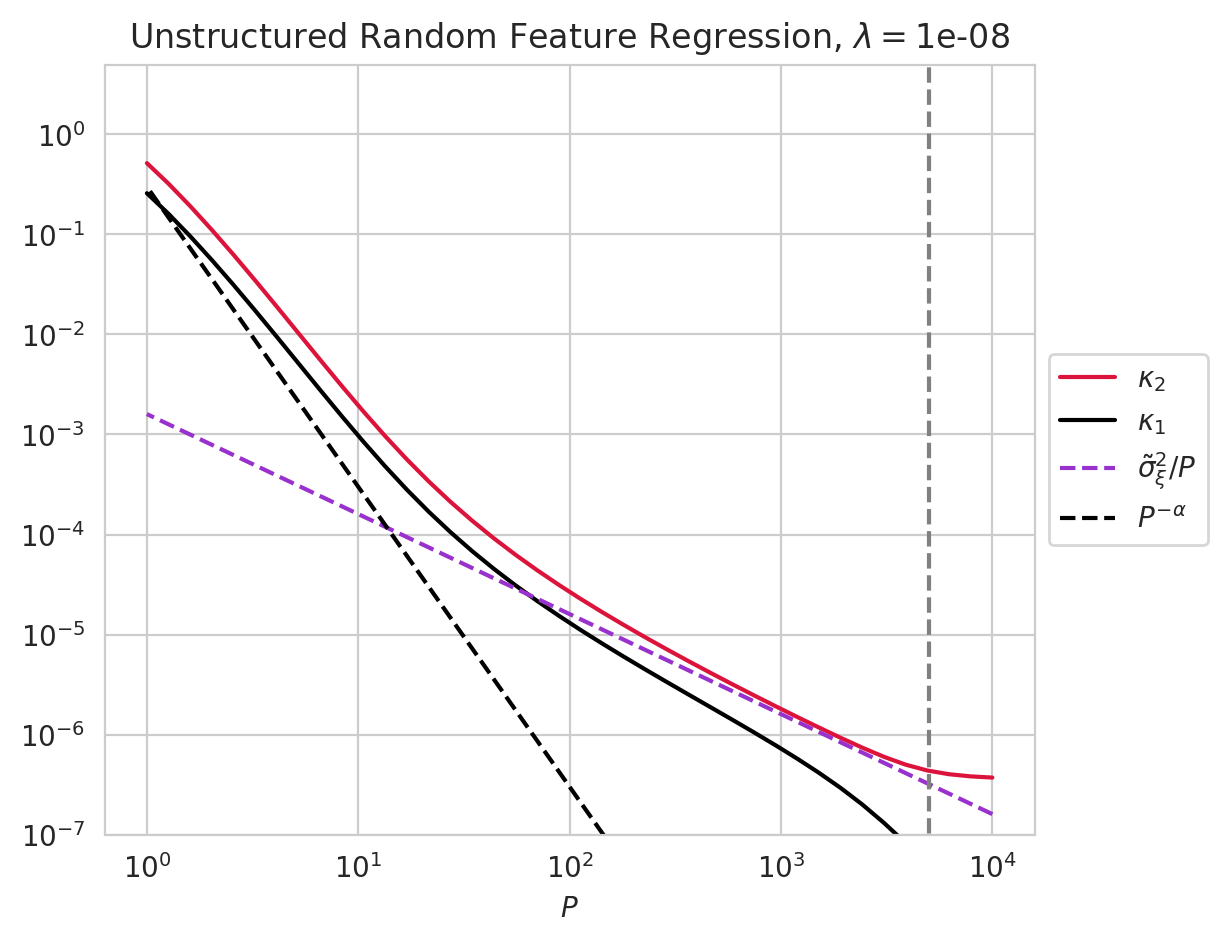

In [64]:
plt.figure(figsize=(6, 5))
plt.plot(ps2, thry['kappa2'], label="$\\kappa_2$", c='crimson')
plt.plot(ps2, thry['kappa1'], label="$\\kappa_1$", c='k')
# plt.plot(ps2, thry['gamma2'], label="$\\gamma_2$", c='coral')
# plt.plot(ps2, thry['gamma1'], label="$\\gamma_1$", c='orange')
# plt.plot(ps2, thry['df1k2_bar'],  c='dodgerblue')
# plt.errorbar(ps, expt['df1'], expt['df1_std'], marker='o', linestyle="", label="$\\overline{{\\mathrm{{df}}}}_1(\\kappa_2)$", c='dodgerblue')
# plt.plot(ps2, thry['df2k2'], label="df$_2(\\kappa_2)$", c='C4')

# plt.errorbar(ps, expt['kappa_GCV'], np.minimum(expt['kappa_GCV_std'], expt['kappa_GCV']*0.9), label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")
plt.plot(ps2, qs2 * sigma_xi**2 , '--', c='darkorchid', label='$\\tilde \\sigma_\\xi^2/P$')
plt.plot(ps2[4:], 3e-1*ps2[4:]**(-alpha1) , '--', c='k', label='$P^{{-\\alpha}}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.plot([N, N], [1e-11, 1e1], linestyle='--', color='grey', label="N")
plt.yscale('log')
plt.xlabel(r'$P$')
plt.ylim(1e-7, 5e0)
plt.title(f"Unstructured Random Feature Regression, $\\lambda=${lamb:.0e}")
plt.savefig('figures/NLRF_transition_params.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Structured Covariates RF Model,\n$r=$0.4, $\\alpha=$3.0, $\\lambda=$1e-08, $\\sigma_\\epsilon$=0, $\\tilde \\sigma_\\xi$=0.04')

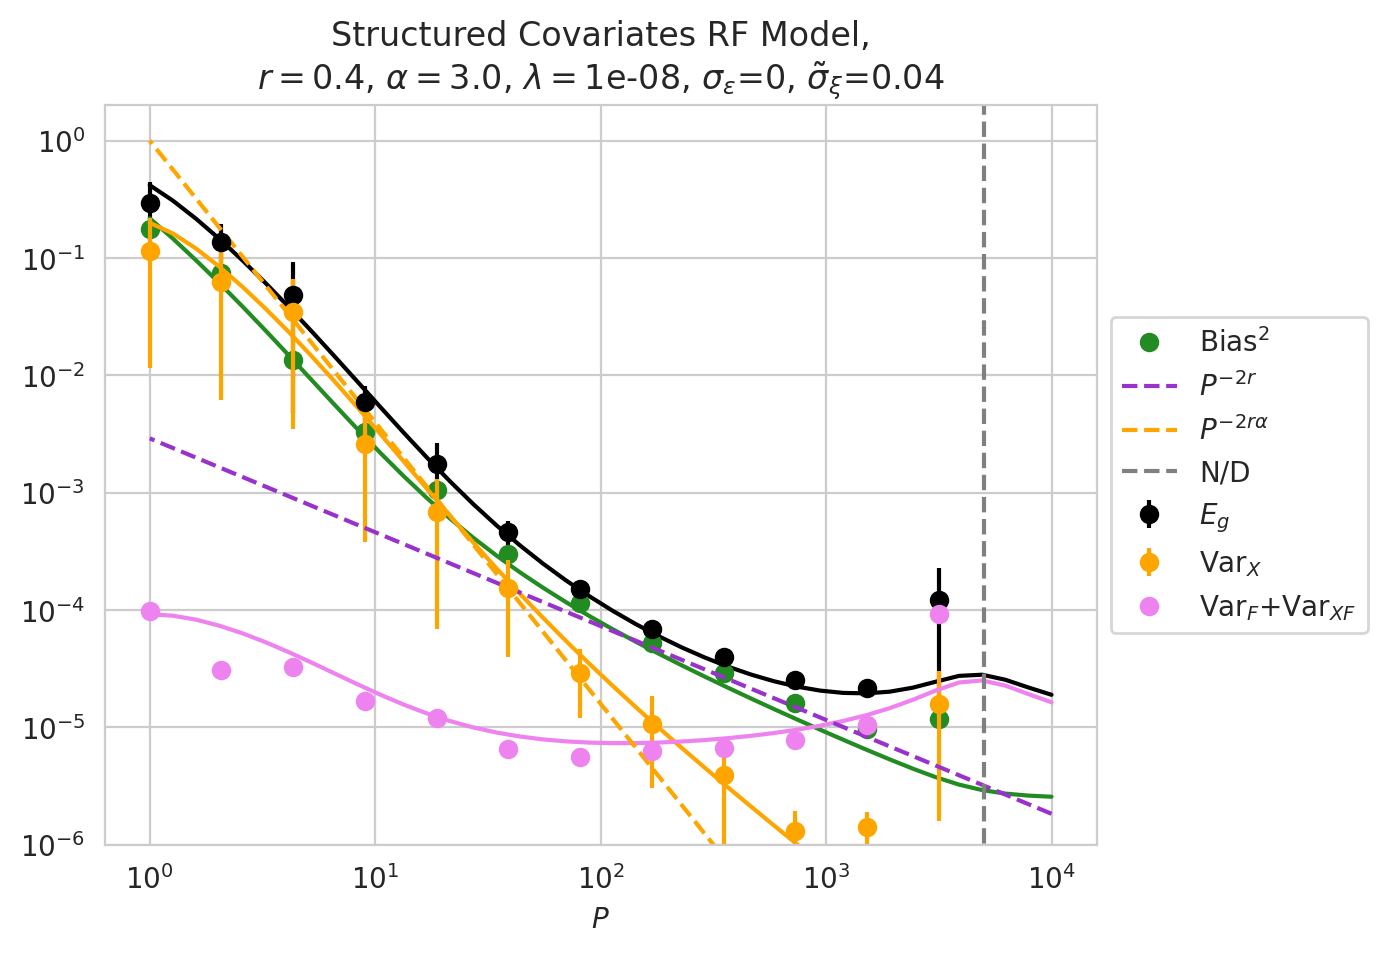

In [63]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF']
colors = ['k', 'b', 'forestgreen', 'orange', 'purple', 'pink']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$"]
for i in range(len(keys)):
    if i in [1, 4, 5]: continue
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(ps, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(ps, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(ps2, thry[key], c=color)

plt.errorbar(ps, expt["VarF"] + expt["VarXF"], ls="", marker='o', c='violet', label="Var$_F$+Var$_{{XF}}$")
plt.plot(ps2, thry['VarF']+thry['VarXF'], c='violet')

# plt.plot(1/qs2, 1e-11*qs2**(min(2*alpha1, a-1)), '--', c='forestgreen', label="$P^{{-(a-1)}}$")
plt.plot(ps2, 5e-1*(ps2/(D*sigma_xi**2))**(-2*r), '--', c='darkorchid', label="$P^{{-2r}}$")
plt.plot(ps2, 1e0*(ps2)**(-2*r*alpha1), '--', c='orange', label="$P^{{-2r\\alpha}}$")

plt.yscale('log')
plt.xscale('log')
plt.plot([N, N], [1e-8, 1e1], linestyle='--', color='grey', label="N/D")
plt.ylim(bottom=1e-6, top=2e0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$P$')
plt.title(f"Structured Covariates RF Model,\n$r=${r}, $\\alpha=${alpha1}, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon$={sigma_epsilon}, $\\tilde \\sigma_\\xi$={sigma_xi_t}")
# plt.savefig('figures/structured_NLRF_Additive_Dom.pdf', bbox_inches='tight')

### Additively Dominated

In [80]:
D = 10_000
N = 5_000
qs = np.logspace(0.5, 4, 12)
qs2 = np.logspace(0, 4, 40)
ps = D/qs 
ps2 = D/qs2
P_te = 200

num_F_seeds = 10
num_X_seeds = 10

sigma_epsilon = 0
sigma_xi_t = 2.5
sigma_xi =  sigma_xi_t * np.sqrt(1/ D)
lamb = 1e-8

alpha1 = 1.8
alpha2 = 0.0
r = 0.4
etasX = jnp.arange(1, D+1)**(-alpha1)
etasF = jnp.arange(1, N+1)**(-alpha2)
SX = jnp.diag(etasX)
w = jnp.arange(1, D+1)**(-(1 + alpha1*(2*r-1))/2)

X_te_key, Xi_te_key = random.split(random.PRNGKey(0))
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
Xi_te = random.normal(Xi_te_key, (P_te, N)) * sigma_xi
y_te = X_te @ w

expt = simulate_theory([D, N], qs, lamb, sigma_epsilon, sigma_xi, etasX, [etasF], w, X_te, Xi_te, y_te, num_X_seeds, num_F_seeds)
thry = solve_theory([D, N], qs2, lamb, sigma_epsilon, sigma_xi, etasX, [etasF], w, anneal_steps=24)


100%|██████████| 12/12 [00:53<00:00,  4.44s/it]


Text(0.5, 1.0, 'Unstructured Regression, $\\lambda=$1e-08')

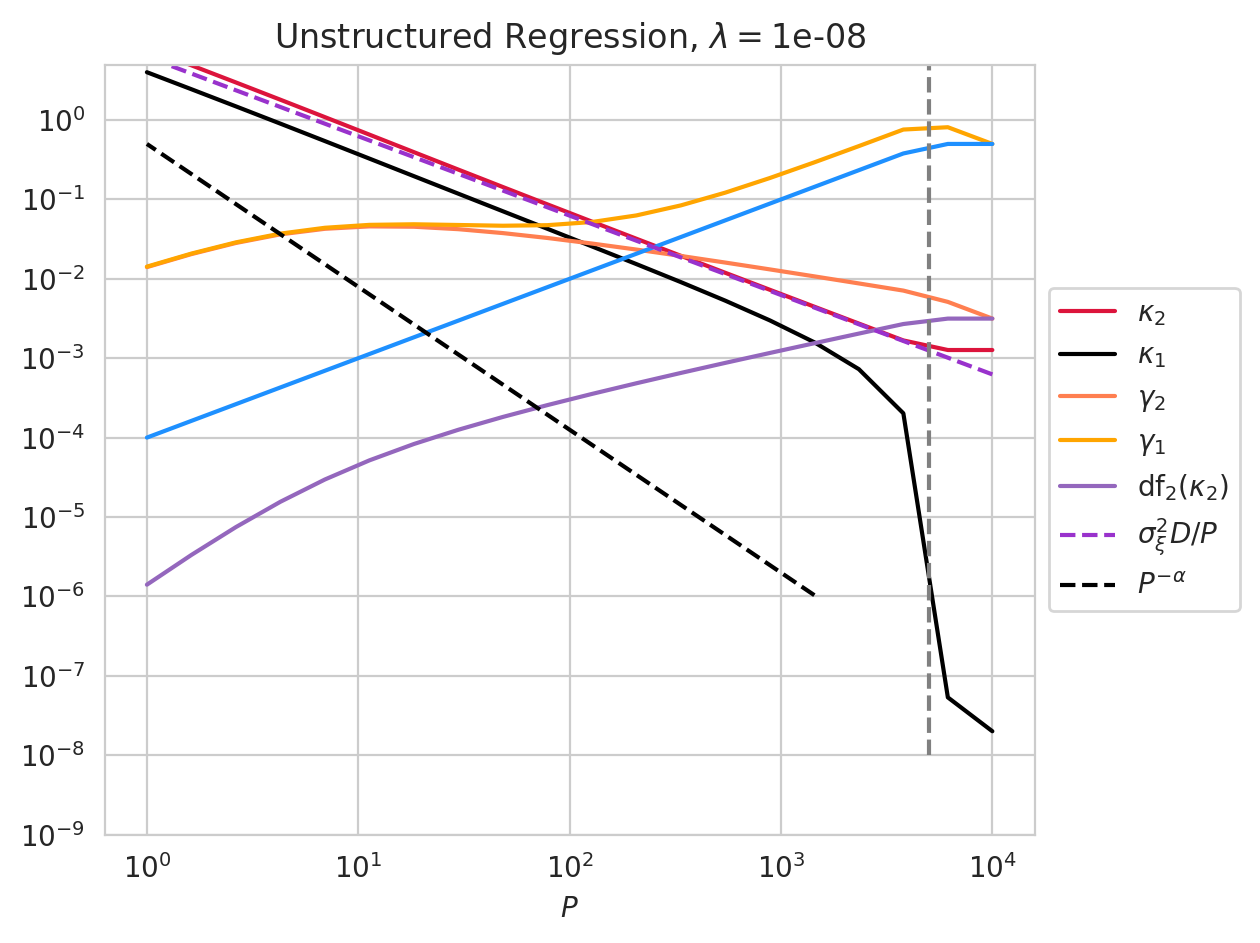

In [8]:
plt.figure(figsize=(6, 5))
plt.plot(ps2, thry['kappa2'], label="$\\kappa_2$", c='crimson')
plt.plot(ps2, thry['kappa1'], label="$\\kappa_1$", c='k')
plt.plot(ps2, thry['gamma2'], label="$\\gamma_2$", c='coral')
plt.plot(ps2, thry['gamma1'], label="$\\gamma_1$", c='orange')
plt.plot(ps2, thry['df1k2_bar'],  c='dodgerblue')
# plt.errorbar(ps2, expt['df1'], expt['df1_std'], marker='o', linestyle="", label="$\\overline{{\\mathrm{{df}}}}_1(\\kappa_2)$", c='dodgerblue')
plt.plot(ps2, thry['df2k2'], label="df$_2(\\kappa_2)$", c='C4')

# plt.errorbar(ps, expt['kappa_GCV'], np.minimum(expt['kappa_GCV_std'], expt['kappa_GCV']*0.9), label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")
plt.plot(ps2, qs2 * sigma_xi**2 , '--', c='darkorchid', label='$\\sigma_\\xi^2 D/P$')
plt.plot(ps2[4:], 5e-1*ps2[4:]**(-alpha1) , '--', c='k', label='$P^{{-\\alpha}}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.plot([N, N], [1e-8, 1e1], linestyle='--', color='grey', label="N")
plt.yscale('log')
plt.xlabel(r'$P$')
plt.ylim(1e-9, 5e0)
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}")
# plt.savefig('figures/NLRF_structured_params_OV.pdf', bbox_inches='tight')

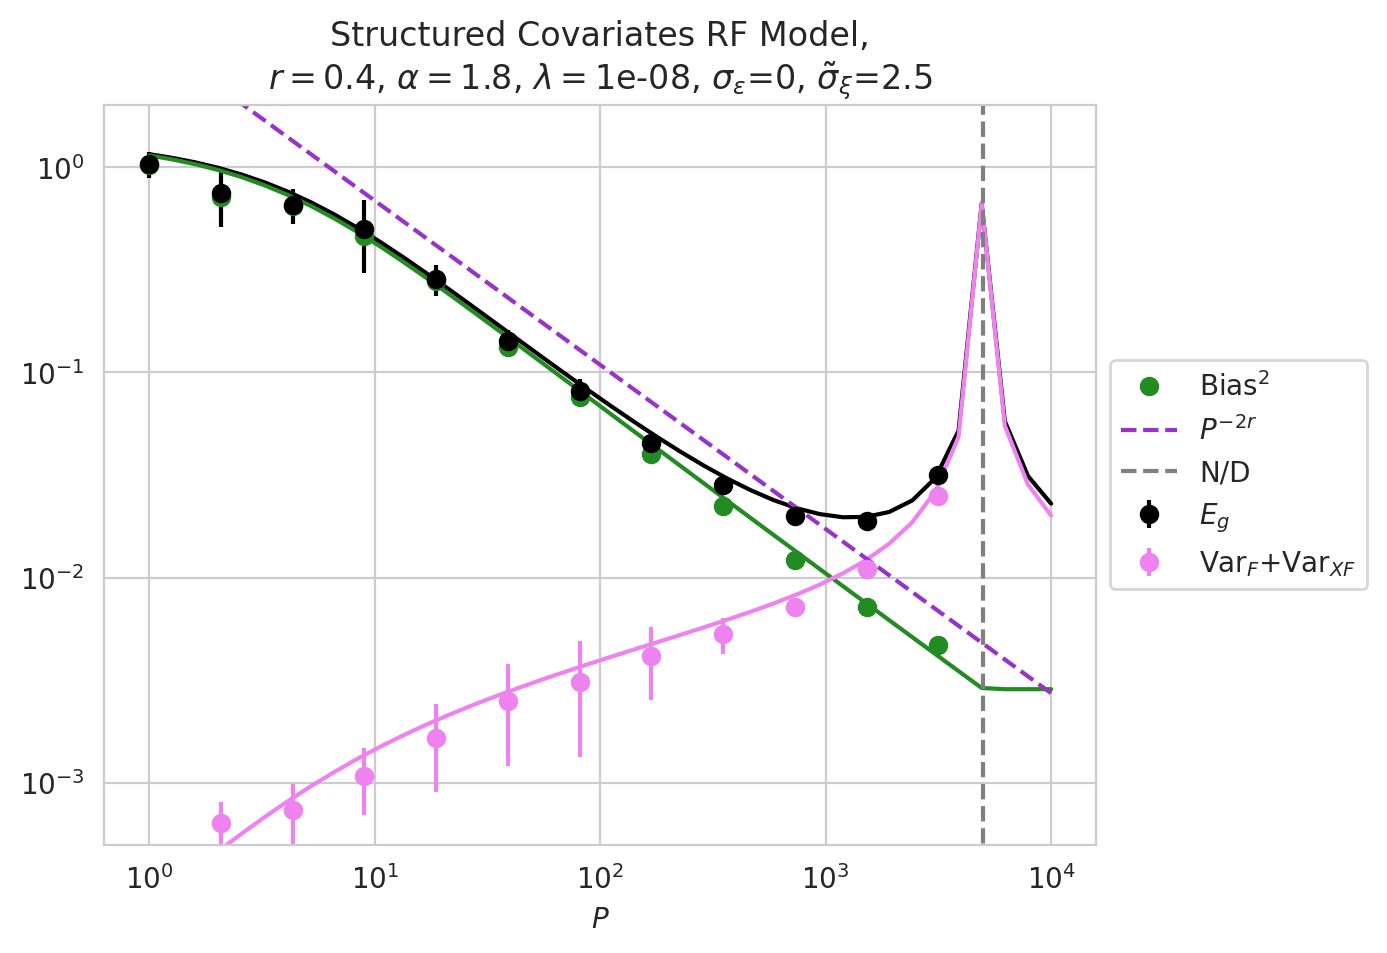

In [81]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF']
colors = ['k', 'b', 'forestgreen', 'orange', 'purple', 'pink']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$"]
for i in range(len(keys)):
    if i in [1, 3, 4, 5]: continue
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(ps, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(ps, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(ps2, thry[key], c=color)

plt.errorbar(ps, expt["VarF"] + expt["VarXF"], np.minimum(expt["VarF"+'_std'], expt["VarF"]*0.9), ls="", marker='o', c='violet', label="Var$_F$+Var$_{{XF}}$")
plt.plot(ps2, thry['VarF']+thry['VarXF'], c='violet')

# plt.plot(1/qs2, 1e-11*qs2**(min(2*alpha1, a-1)), '--', c='forestgreen', label="$P^{{-(a-1)}}$")
plt.plot(ps2, (ps2/(D*sigma_xi**2))**(-2*r), '--', c='darkorchid', label="$P^{{-2r}}$")
# plt.plot(ps2, 1e0*(ps2)**(-2*r*alpha1), '--', c='orange', label="$P^{{-2r\\alpha}}$")

plt.yscale('log')
plt.xscale('log')
plt.plot([N, N], [1e-8, 1e1], linestyle='--', color='grey', label="N/D")
plt.ylim(bottom=5e-4, top=2e0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$P$')
plt.title(f"Structured Covariates RF Model,\n$r=${r}, $\\alpha=${alpha1}, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon$={sigma_epsilon}, $\\tilde \\sigma_\\xi$={sigma_xi_t}")
plt.savefig('figures/structured_NLRF_Additive_Dom.pdf', bbox_inches='tight')

### Additive and Multiplicative

In [82]:
D = 10_000
N = 5000
qs = np.logspace(0.5, 4, 10)
qs2 = np.logspace(0, 4, 40)
ps = D/qs 
ps2 = D/qs2
P_te = 200

num_F_seeds = 10
num_X_seeds = 10

sigma_epsilon = 0
sigma_xi_t = 1.0
sigma_xi = sigma_xi_t* np.sqrt(1/ D)
lamb=1e-8

alpha1 = 1.8
alpha2 = 0.0
r = 1.2
etasX = jnp.arange(1, D+1)**(-alpha1)
etasF = jnp.arange(1, N+1)**(-alpha2)
SX = jnp.diag(etasX)
w = jnp.arange(1, D+1)**(-(1 + alpha1*(2*r-1))/2)

X_te_key, Xi_te_key = random.split(random.PRNGKey(0))
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
Xi_te = random.normal(Xi_te_key, (P_te, N)) * sigma_xi
y_te = X_te @ w

expt = simulate_theory([D, N], qs, lamb, sigma_epsilon, sigma_xi, etasX, [etasF], w, X_te, Xi_te, y_te, num_X_seeds, num_F_seeds)

thry = solve_theory([D, N], qs2, lamb, sigma_epsilon, sigma_xi, etasX, [etasF], w, anneal_steps=8)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:48<00:00,  4.89s/it]


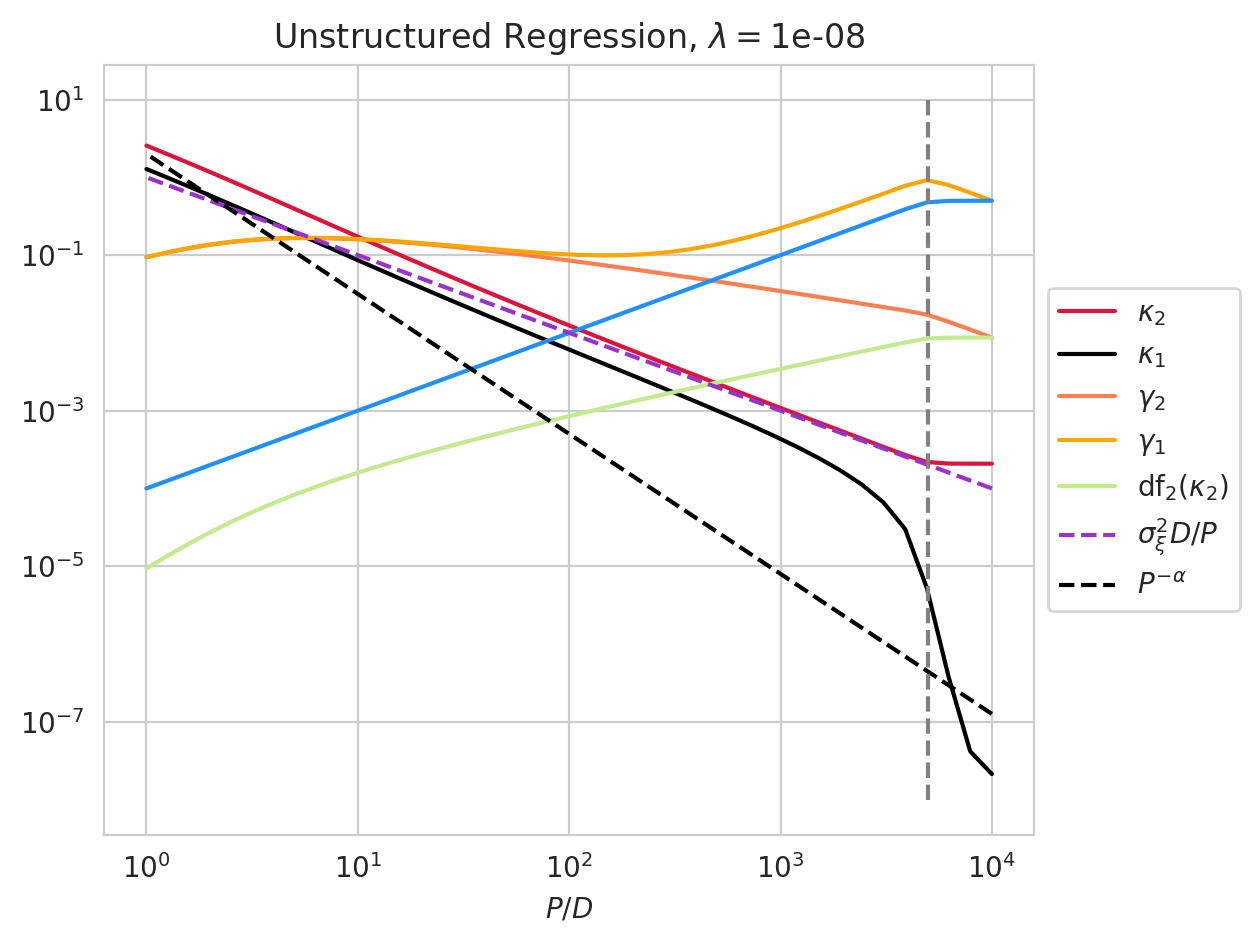

In [436]:
plt.figure(figsize=(6, 5))
plt.plot(ps2, thry['kappa2'], label="$\\kappa_2$", c='crimson')
plt.plot(ps2, thry['kappa1'], label="$\\kappa_1$", c='k')
plt.plot(ps2, thry['gamma2'], label="$\\gamma_2$", c='coral')
plt.plot(ps2, thry['gamma1'], label="$\\gamma_1$", c='orange')
plt.plot(ps2, thry['df1k2_bar'],  c='dodgerblue')
# plt.errorbar(ps2, expt['df1'], expt['df1_std'], marker='o', linestyle="", label="$\\overline{{\\mathrm{{df}}}}_1(\\kappa_2)$", c='dodgerblue')
plt.plot(ps2, thry['df2k2'], label="df$_2(\\kappa_2)$", c='C4')

# plt.errorbar(ps, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")
plt.plot(ps2, qs2 * sigma_xi**2 , '--', c='darkorchid', label='$\\sigma_\\xi^2 D/P$')
plt.plot(ps2, 2*ps2**(-alpha1) , '--', c='k', label='$P^{{-\\alpha}}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.plot([N, N], [1e-8, 1e1], linestyle='--', color='grey', label="N")
plt.yscale('log')
plt.xlabel(r'$P/D$')
# plt.ylim(1e-5, 5e0)
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}")
plt.savefig('figures/structured_NLRF_Full_Dom_params.pdf', bbox_inches='tight')

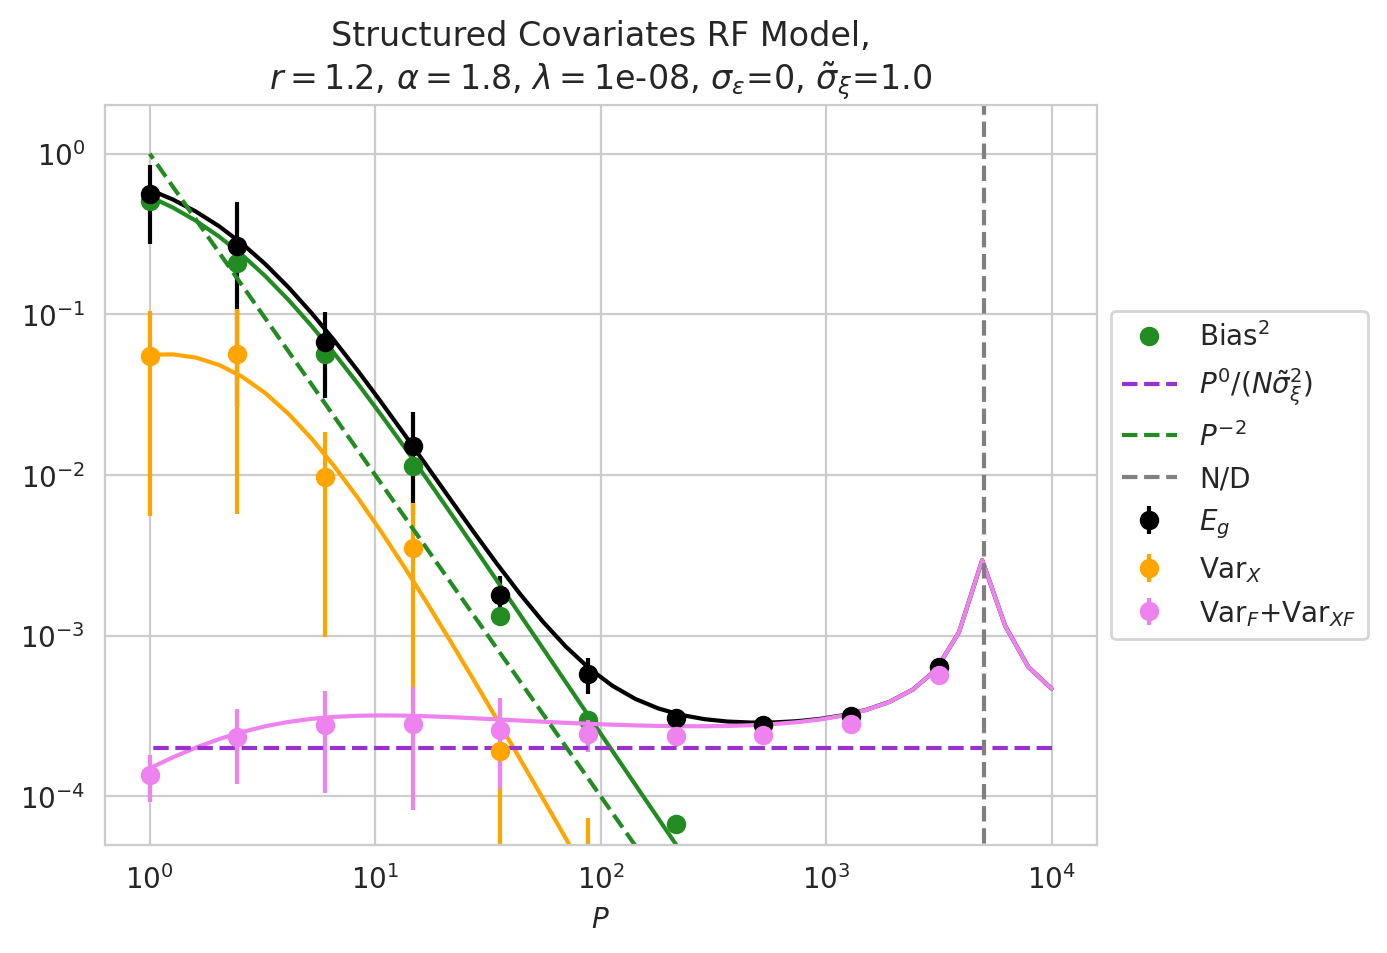

In [83]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF']
colors = ['k', 'b', 'forestgreen', 'orange', 'purple', 'pink']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$"]
for i in range(len(keys)):
    if i in [1, 4, 5]: continue
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(ps, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(ps, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(ps2, thry[key], c=color)

plt.errorbar(ps, expt["VarF"] + expt["VarXF"], np.minimum(expt["VarF"+'_std'], expt["VarF"]*0.9), ls="", marker='o', c='violet', label="Var$_F$+Var$_{{XF}}$")
plt.plot(ps2, thry['VarF']+thry['VarXF'], c='violet')

# plt.plot(1/qs2, 1e-11*qs2**(min(2*alpha1, a-1)), '--', c='forestgreen', label="$P^{{-(a-1)}}$")
plt.plot(ps2, (ps2**0)/(N*D*sigma_xi**2), '--', c='darkorchid', label="$P^{{0}}/(N \\tilde \\sigma_\\xi^2)$")
plt.plot(ps2, 1e0*(ps2)**(-2), '--', c='forestgreen', label="$P^{{-2}}$")

plt.yscale('log')
plt.xscale('log')
plt.plot([N, N], [1e-8, 1e1], linestyle='--', color='grey', label="N/D")
plt.ylim(bottom=5e-5, top=2e0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$P$')
plt.title(f"Structured Covariates RF Model,\n$r=${r}, $\\alpha=${alpha1}, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon$={sigma_epsilon}, $\\tilde \\sigma_\\xi$={sigma_xi_t}")
plt.savefig('figures/structured_NLRF_Full_Dom.pdf', bbox_inches='tight')

### Noise Mitigated

In [72]:
D = 10_000
N = 5000
qs = np.logspace(0.5, 4, 10)
qs2 = np.logspace(0, 4, 40)
ps = D/qs 
ps2 = D/qs2
P_te = 200

alpha1 = 3.5
alpha2 = 0.0
r = 0.8

num_F_seeds = 25
num_X_seeds = 25

sigma_epsilon = 8e-1
sigma_xi_t = 1e-1
sigma_xi =  sigma_xi_t * np.sqrt(1/D)


etasX = jnp.arange(1, D+1)**(-alpha1)
etasF = jnp.arange(1, N+1)**(-alpha2)
SX = jnp.diag(etasX)
w = jnp.arange(1, D+1)**(-(1 + alpha1*(2*r-1))/2)

X_te_key, Xi_te_key = random.split(random.PRNGKey(0))
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
Xi_te = random.normal(Xi_te_key, (P_te, N)) * sigma_xi
y_te = X_te @ w

expt = simulate_theory([D, N], qs, lamb, sigma_epsilon, sigma_xi, etasX, [etasF], w, X_te, Xi_te, y_te, num_X_seeds, num_F_seeds)

thry = solve_theory([D, N], qs2, lamb, sigma_epsilon, sigma_xi, etasX, [etasF], w, anneal_steps=8)


100%|██████████| 10/10 [04:52<00:00, 29.29s/it]


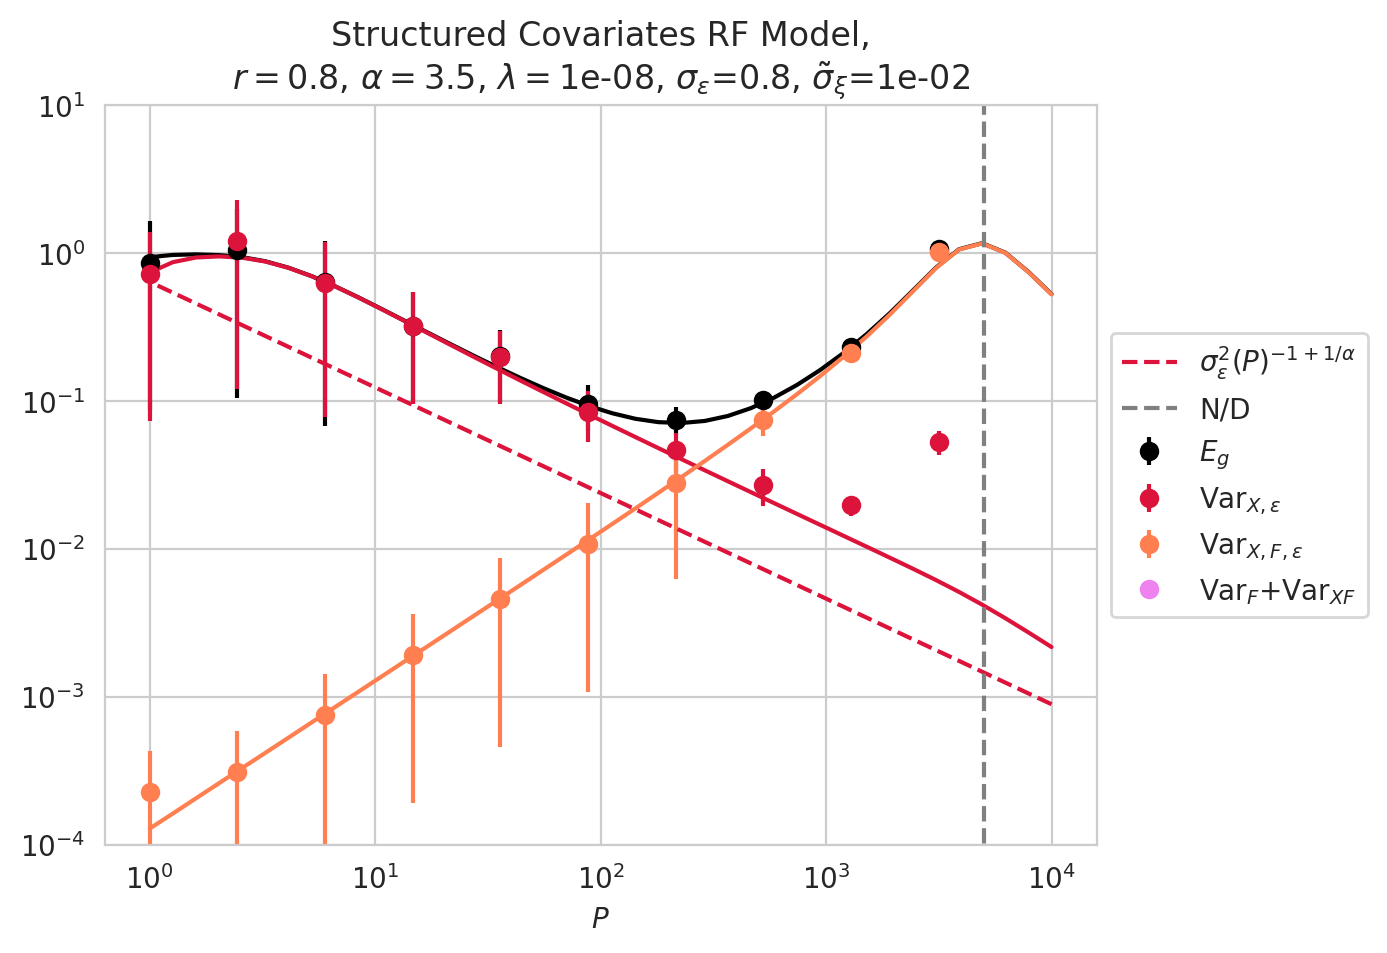

In [79]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF', 'VarXe', 'VarXFe']
colors = ['k', 'b', 'forestgreen', 'orange', 'purple', 'pink', 'crimson', 'coral']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$", "Var$_{{X, \\epsilon}}$", "Var$_{{X, F, \\epsilon}}$"]
for i in range(len(keys)):
    if i in [1, 2, 3, 4, 5]: continue
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(ps, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(ps, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(ps2, thry[key], c=color)

plt.errorbar(ps, expt["VarF"] + expt["VarXF"], ls="", marker='o', c='violet', label="Var$_F$+Var$_{{XF}}$")
plt.plot(ps2, thry['VarF']+thry['VarXF'], c='violet')

plt.plot(ps2, sigma_epsilon**2*(ps2)**(-1+1/alpha1), '--', c='crimson', label="$\\sigma_\\epsilon^2 (P)^{{-1 + 1/\\alpha}}$")
# plt.plot(ps2, 1e0*(ps2)**(-2 * r), '--', c='forestgreen', label="$P^{{-2 r}}$")

plt.yscale('log')
plt.xscale('log')
plt.plot([N, N], [1e-8, 1e2], linestyle='--', color='grey', label="N/D")
plt.ylim(bottom=1e-4, top=1e1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$P$')
plt.title(f"Structured Covariates RF Model,\n$r=${r}, $\\alpha=${alpha1}, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon$={sigma_epsilon}, $\\tilde \\sigma_\\xi$={1e-2:.0e}")
plt.savefig('figures/structured_NLRF_Noise_Mit.pdf', bbox_inches='tight')

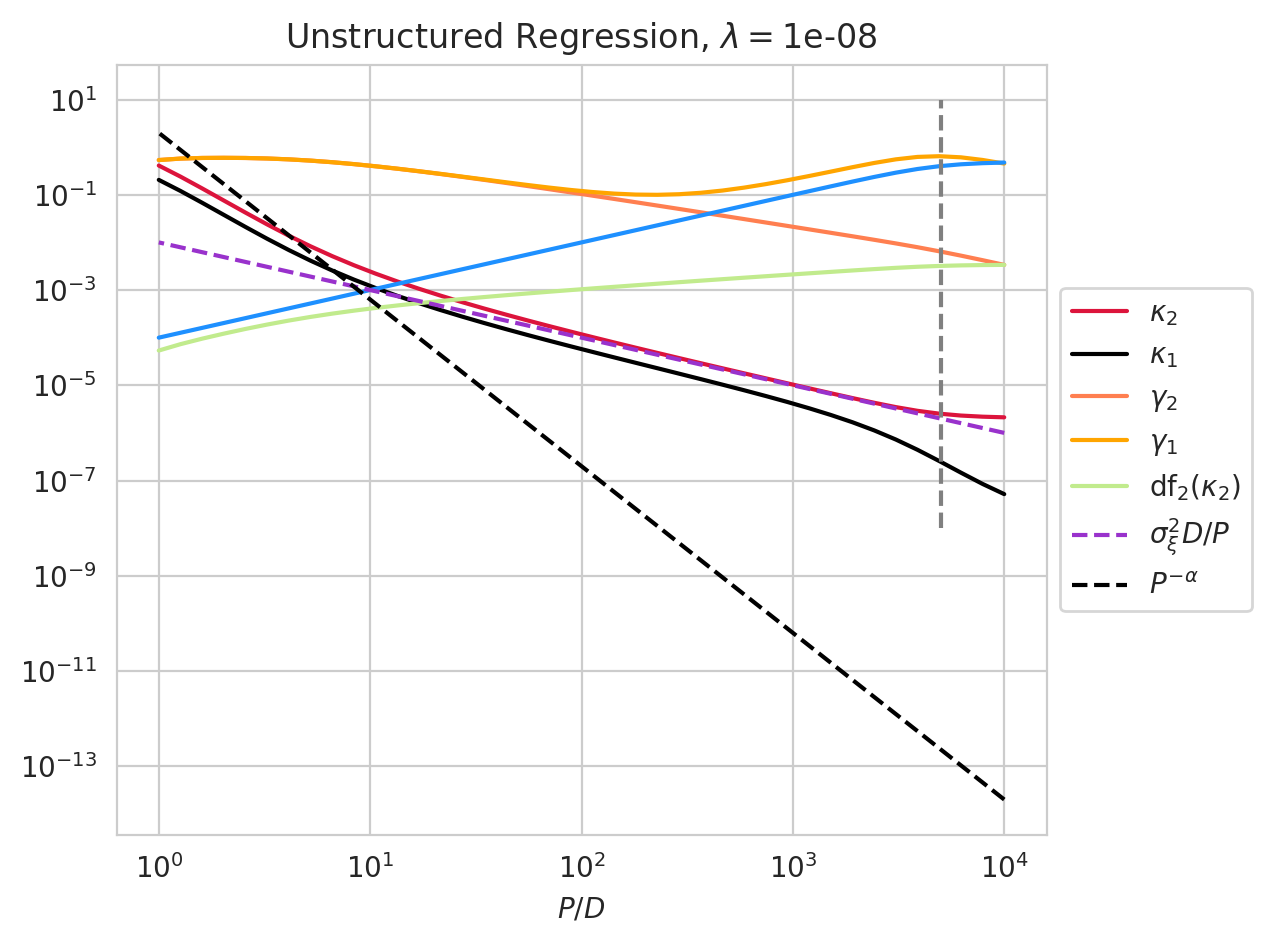

In [440]:
plt.figure(figsize=(6, 5))
plt.plot(ps2, thry['kappa2'], label="$\\kappa_2$", c='crimson')
plt.plot(ps2, thry['kappa1'], label="$\\kappa_1$", c='k')
plt.plot(ps2, thry['gamma2'], label="$\\gamma_2$", c='coral')
plt.plot(ps2, thry['gamma1'], label="$\\gamma_1$", c='orange')
plt.plot(ps2, thry['df1k2_bar'],  c='dodgerblue')
# plt.errorbar(ps2, expt['df1'], expt['df1_std'], marker='o', linestyle="", label="$\\overline{{\\mathrm{{df}}}}_1(\\kappa_2)$", c='dodgerblue')
plt.plot(ps2, thry['df2k2'], label="df$_2(\\kappa_2)$", c='C4')

# plt.errorbar(ps, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")
plt.plot(ps2, qs2 * sigma_xi**2 , '--', c='darkorchid', label='$\\sigma_\\xi^2 D/P$')
plt.plot(ps2, 2*ps2**(-alpha1) , '--', c='k', label='$P^{{-\\alpha}}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.plot([N, N], [1e-8, 1e1], linestyle='--', color='grey', label="N")
plt.yscale('log')
plt.xlabel(r'$P/D$')
# plt.ylim(1e-5, 5e0)
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}")
plt.savefig('figures/structured_NLRF_Noise_Mit_params.pdf', bbox_inches='tight')